In [3]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import sys
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

import logging
logging.getLogger().setLevel(logging.INFO)
from dotenv import load_dotenv
load_dotenv()

sys.path.append(os.path.realpath('../'))

DROOT = '../1-data/'

cities = pd.read_csv(os.path.join(DROOT, '1-research', 'cities.latest.csv'), index_col=False)
cities.head(3)

city_id  city_name country_id  city_id.1  priority  n_cells   n_req  \
0     2167  Amsterdam        NLD     2167.0         0    345.0  5520.0   
1     2226     Arnhem        NLD     2226.0         0     87.0  1392.0   
2     2205  Eindhoven        NLD     2205.0         0    104.0  1664.0   

   n_req_ok  frac_req_ok  city_centr_lat  city_centr_lon  region  
0    5520.0          1.0       52.355712        4.850578  Europe  
1    1392.0          1.0       51.965241        5.930034  Europe  
2    1664.0          1.0       51.444330        5.465134  Europe

# Aggregate all Pickles
Also make some initial data exploration. 

In [6]:
isochrones_list[-2]

uid  pid                    startpt  \
0          621-0-transit_off-15m-g    0  POINT (-74.05196 4.81839)   
1          621-0-transit_off-30m-g    0  POINT (-74.05196 4.81839)   
2         621-0-transit_peak-15m-g    0  POINT (-74.05196 4.81839)   
3         621-0-transit_peak-30m-g    0  POINT (-74.05196 4.81839)   
4     621-0-transit_bike_off-15m-g    0  POINT (-74.05196 4.81839)   
...                            ...  ...                        ...   
8603    621-537-driving_peak-25m-g  537  POINT (-74.09989 4.47828)   
8604         621-537-cycling-15m-g  537  POINT (-74.09989 4.47828)   
8605         621-537-cycling-30m-g  537  POINT (-74.09989 4.47828)   
8606         621-537-walking-15m-g  537  POINT (-74.09989 4.47828)   
8607         621-537-walking-30m-g  537  POINT (-74.09989 4.47828)   

                trmode   trmode_type  tt_mnts  tt_mnts_std  \
0          transit_off       transit       15           15   
1          transit_off       transit       30           30   
2         transit_peak       transit       15           15   
3         transit_peak       transit       30           30   
4     transit_bike_off  transit_bike       15           15   
...                ...           ...      ...          ...   
8603      driving_peak       driving       25           30   
8604           cycling       cycling       15           15   
8605           cycling       cycling       30           30   
8606           walking       walking       15           15   
8607           walking       walking       30           30   

                        dep_dt source  city_id  \
0    2023-08-22 13:30:00-05:00      g      621   
1    2023-08-22 13:30:00-05:00      g      621   
2    2023-08-22 08:30:00-05:00      g      621   
3    2023-08-22 08:30:00-05:00      g      621   
4    2023-08-22 13:30:00-05:00      g      621   
...                        ...    ...      ...   
8603 2023-08-22 08:30:00-05:00      g      621   
8604 2023-08-22 08:30:00-05:00      g      621   
8605 2023-08-22 08:30:00-05:00      g      621   
8606 2023-08-22 08:30:00-05:00      g      621   
8607 2023-08-22 08:30:00-05:00      g      621   

                                              isochrone  cache_avail  \
0     MULTIPOLYGON (((-74.04343 4.81664, -74.04343 4...         True   
1     MULTIPOLYGON (((-74.03602 4.81759, -74.03579 4...         True   
2     MULTIPOLYGON (((-74.04343 4.81664, -74.04343 4...         True   
3     MULTIPOLYGON (((-74.03602 4.81759, -74.03579 4...         True   
4     MULTIPOLYGON (((-74.07460 4.81613, -74.07390 4...         True   
...                                                 ...          ...   
8603  POLYGON ((-74.15602 4.54862, -74.15694 4.55013...         True   
8604  POLYGON ((-74.12363 4.47020, -74.12415 4.47129...         True   
8605  POLYGON ((-74.12560 4.52384, -74.12960 4.53408...         True   
8606  POLYGON ((-74.10933 4.47883, -74.10657 4.48248...         True   
8607  POLYGON ((-74.11114 4.48610, -74.10886 4.48740...         True   

          cell_pop                                             raster  \
0     14619.833008  POLYGON ((-74.05724 4.82244, -74.05669 4.81434...   
1     14619.833008  POLYGON ((-74.05724 4.82244, -74.05669 4.81434...   
2     14619.833008  POLYGON ((-74.05724 4.82244, -74.05669 4.81434...   
3     14619.833008  POLYGON ((-74.05724 4.82244, -74.05669 4.81434...   
4     14619.833008  POLYGON ((-74.05724 4.82244, -74.05669 4.81434...   
...            ...                                                ...   
8603   1452.400513  POLYGON ((-74.10514 4.48233, -74.10464 4.47423...   
8604   1452.400513  POLYGON ((-74.10514 4.48233, -74.10464 4.47423...   
8605   1452.400513  POLYGON ((-74.10514 4.48233, -74.10464 4.47423...   
8606   1452.400513  POLYGON ((-74.10514 4.48233, -74.10464 4.47423...   
8607   1452.400513  POLYGON ((-74.10514 4.48233, -74.10464 4.47423...   

                                          isochrone_buf     reach_km2  \
0     POLYGON ((-74.05644 4.8

hlelo


In [37]:
for i, (pid, city) in enumerate(cities.iterrows()):
    
    isochrone_path = os.path.join(DROOT, '3-traveltime-cities', f'{city.city_id}.isochrones.pcl')
    if not os.path.exists(isochrone_path):
        continue;
    
    # Extract urban center and read in as pickle
    logging.info(f"Loading {city.city_name} ({city.city_id})")
    isochrones = gpd.GeoDataFrame(pd.read_pickle(isochrone_path))

    if isochrones.columns[15] == 'reach_km2':
        cols = list(isochrones.columns)
        cols[15] = 'raster_km2'
        isochrones.columns = cols
        print("hlelo")
    
    isochrones.to_pickle(isochrone_path)


INFO:root:Loading Amsterdam (2167)


hlelo


INFO:root:Loading Arnhem (2226)


hlelo


INFO:root:Loading Eindhoven (2205)


hlelo


INFO:root:Loading Groningen (2269)


hlelo


INFO:root:Loading Leiden (2138)


hlelo


INFO:root:Loading Maastricht (2220)


hlelo


INFO:root:Loading Nijmegen (2219)


hlelo


INFO:root:Loading Rotterdam [The Hague] (2123)


hlelo


INFO:root:Loading Tilburg (2183)


hlelo


INFO:root:Loading Utrecht (2181)


hlelo


INFO:root:Loading s-Hertogenbosch (2194)


hlelo


INFO:root:Loading Graz (3000)


hlelo


INFO:root:Loading Innsbruck (2788)
INFO:root:Loading Vienna (3027)


hlelo
hlelo


INFO:root:Loading Brussels (2135)


hlelo


INFO:root:Loading Bern (2384)


hlelo


INFO:root:Loading Prague (2927)


hlelo


INFO:root:Loading Hamburg (2531)


hlelo


INFO:root:Loading Aarhus (2518)


hlelo


INFO:root:Loading Copenhagen (2749)


hlelo


INFO:root:Loading Tallinn (3255)


hlelo


INFO:root:Loading Helsinki (3244)


hlelo


INFO:root:Loading Paris (2046)


hlelo


INFO:root:Loading Birmingham (1800)


hlelo


INFO:root:Loading York (1874)
INFO:root:Loading Dublin (1656)


hlelo
hlelo


INFO:root:Loading Perth (11640)


hlelo


INFO:root:Loading Sydney (13043)


hlelo


INFO:root:Loading Rio de Janeiro (1361)


hlelo


INFO:root:Loading Calgary (362)


hlelo


INFO:root:Loading Montreal (1017)


hlelo


INFO:root:Loading Toronto (875)


hlelo


INFO:root:Loading Bogota (621)


hlelo


INFO:root:Loading São Paulo (1303)


hlelo


In [38]:
isochrones_list = []
for i, (pid, city) in enumerate(cities.iterrows()):
    
    isochrone_path = os.path.join(DROOT, '3-traveltime-cities', f'{city.city_id}.isochrones.pcl')
    if not os.path.exists(isochrone_path):
        continue;
    
    # Extract urban center and read in as pickle
    logging.info(f"Loading {city.city_name} ({city.city_id})")
    
    isochrones = gpd.GeoDataFrame(pd.read_pickle(isochrone_path))
    isochrones.insert(4, 'trmode_type', isochrones.trmode.str.replace('_off', '').str.replace('_peak', ''))
    isochrones.insert(6, 'tt_mnts_std', isochrones.tt_mnts.replace({10: 15, 25: 30}))
    
    isochrones_list.append(isochrones)

isochrones = pd.concat(isochrones_list)
isochrones = isochrones.merge(cities[['city_name', 'city_id', 'country_id']])
isochrones.sample(2)

INFO:root:Loading Amsterdam (2167)
INFO:root:Loading Arnhem (2226)
INFO:root:Loading Eindhoven (2205)
INFO:root:Loading Groningen (2269)
INFO:root:Loading Leiden (2138)
INFO:root:Loading Maastricht (2220)
INFO:root:Loading Nijmegen (2219)
INFO:root:Loading Rotterdam [The Hague] (2123)
INFO:root:Loading Tilburg (2183)
INFO:root:Loading Utrecht (2181)
INFO:root:Loading s-Hertogenbosch (2194)
INFO:root:Loading Graz (3000)
INFO:root:Loading Innsbruck (2788)
INFO:root:Loading Vienna (3027)
INFO:root:Loading Brussels (2135)
INFO:root:Loading Bern (2384)
INFO:root:Loading Prague (2927)
INFO:root:Loading Hamburg (2531)
INFO:root:Loading Aarhus (2518)
INFO:root:Loading Copenhagen (2749)
INFO:root:Loading Tallinn (3255)
INFO:root:Loading Helsinki (3244)
INFO:root:Loading Paris (2046)
INFO:root:Loading Birmingham (1800)
INFO:root:Loading York (1874)
INFO:root:Loading Dublin (1656)
INFO:root:Loading Perth (11640)
INFO:root:Loading Sydney (13043)
INFO:root:Loading Rio de Janeiro (1361)
INFO:root:Lo

uid   pid                      startpt  \
31189   3027-181-transit_bike_off-30m-g   181    POINT (16.39131 48.20761)   
259240      1303-1742-driving_off-10m-g  1742  POINT (-46.66999 -23.69415)   

                  trmode   trmode_type  tt_mnts  tt_mnts_std  \
31189   transit_bike_off  transit_bike       30           30   
259240       driving_off       driving       10           15   

                           dep_dt source  city_id  ...  \
31189   2023-08-22 13:30:00+02:00      g     3027  ...   
259240  2023-08-22 13:30:00-03:00      g     1303  ...   

                                                   raster  \
31189   POLYGON ((16.38583 48.21233, 16.38393 48.20290...   
259240  POLYGON ((-46.67433 -23.68996, -46.67618 -23.6...   

                                            isochrone_buf     reach_km2  \
31189   MULTIPOLYGON (((16.24781 48.19924, 16.24767 48...  1.668105e+08   
259240  POLYGON ((-46.71068 -23.66713, -46.71123 -23.6...  3.196023e+07   

       reach_n    raster_km2     reach_pop  \
31189    310.0  3.100632e+08  1.658324e+06   
259240    63.0  6.270853e+07  7.677186e+05   

                                                reach_geo  isochrone_km2  \
31189   MULTIPOLYGON (((16.286435535756606 48.16521916...            NaN   
259240  POLYGON ((-46.70096482414772 -23.7150573208186...            NaN   

        city_name country_id  
31189      Vienna        AUT  
259240  São Paulo        BRA  

[2 rows x 23 columns]

## Competitiveness of biking, transit, walk+transit and bike+transit compared to car traffic.

In [39]:
reach_gdf = isochrones.pivot_table(index=['city_id', 'pid'], values=['reach_pop', 'reach_geo', 'reach_km2'], columns=['tt_mnts_std', 'trmode'], aggfunc=lambda x: x)
reach_gdf = gpd.GeoDataFrame(reach_gdf)
for tt_min, trmode in reach_gdf[('reach_geo')]:
    cols = ('reach_geo', tt_min, trmode)
    reach_gdf[cols] = gpd.GeoSeries(reach_gdf[cols]).set_crs('EPSG:4326')
reach_gdf.head(2)

reach_geo  \
tt_mnts_std                                                 15   
trmode                                                 cycling   
city_id pid                                                      
362     0    POLYGON ((-114.17542 51.15612, -114.19049 51.1...   
        1    POLYGON ((-114.30722 51.14649, -114.29387 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                             driving_off   
city_id pid                                                      
362     0    POLYGON ((-114.18877 51.15612, -114.20384 51.1...   
        1    POLYGON ((-114.30722 51.14649, -114.32230 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                            driving_peak   
city_id pid                                                      
362     0    POLYGON ((-114.24218 51.15612, -114.22883 51.1...   
        1    POLYGON ((-114.29215 51.13685, -114.30722 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                        transit_bike_off   
city_id pid                                                      
362     0    POLYGON ((-114.17713 51.16576, -114.19221 51.1...   
        1    POLYGON ((-114.27709 51.12722, -114.29215 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                       transit_bike_peak   
city_id pid                                                      
362     0    POLYGON ((-114.17713 51.16576, -114.19221 51.1...   
        1    POLYGON ((-114.27709 51.12722, -114.29215 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                             transit_off   
city_id pid                                                      
362     0    POLYGON ((-114.14872 51.15612, -114.16378 51.1...   
        1    POLYGON ((-114.26545 51.13685, -114.28052 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                            transit_peak   
city_id pid                                                      
362     0    POLYGON ((-114.10696 51.14649, -114.12031 51.1...   
        1    POLYGON ((-114.26545 51.13685, -114.28052 51.1...   

                                                                \
tt_mnts_std                                                      
trmode                                                 walking   
city_id pid                                                      
362     0    POLYGON ((-114.10696 51.14649, -114.12031 51.1...   
        1    POLYGON ((-114.28052 51.14649, -114.26717 51.1...   

                                                                \
tt_mnts_std                                                 30   
trmode                                                 cycling   
city_id pid                                                      
362     0    POLYGON ((-114.24218 51.15612, -114.25726 51.1...   
        1    POLYGON ((-114.33565 51.15612, -114.35074 51.1...   

                                                                ...  \
tt_mnts_std                                                     ...   
trmode                                             driving_off  ...   
city_id pid                                                     ...   
362     0    POLYGON ((-114.44542 51.09832, -114.43208 51.0...  ...   
        1    MULTIPOLYGON (((-114.43183 51.02129, -114.4451...  ...   

                reach_pop                            

In [40]:
grid = isochrones[['pid', 'startpt', 'raster', 'city_id', 'city_name', 'country_id']].drop_duplicates()
grid

pid                      startpt  \
0          0     POINT (4.78390 52.51746)   
16         1     POINT (4.75601 52.50772)   
32         2     POINT (4.76962 52.50772)   
48         3     POINT (4.78323 52.50772)   
64         4     POINT (4.79684 52.50772)   
...      ...                          ...   
263360  2000  POINT (-46.72391 -23.79453)   
263376  2001  POINT (-46.71337 -23.79453)   
263392  2002  POINT (-46.73632 -23.80290)   
263408  2003  POINT (-46.72578 -23.80290)   
263424  2004  POINT (-46.73818 -23.81126)   

                                                   raster  city_id  city_name  \
0       POLYGON ((4.77743 52.52233, 4.77676 52.51259, ...     2167  Amsterdam   
16      POLYGON ((4.74954 52.51259, 4.74888 52.50285, ...     2167  Amsterdam   
32      POLYGON ((4.76315 52.51259, 4.76248 52.50285, ...     2167  Amsterdam   
48      POLYGON ((4.77676 52.51259, 4.77609 52.50285, ...     2167  Amsterdam   
64      POLYGON ((4.79037 52.51259, 4.78970 52.50285, ...     2167  Amsterdam   
...                                                   ...      ...        ...   
263360  POLYGON ((-46.72825 -23.79035, -46.73011 -23.7...     1303  São Paulo   
263376  POLYGON ((-46.71771 -23.79035, -46.71957 -23.7...     1303  São Paulo   
263392  POLYGON ((-46.74066 -23.79871, -46.74252 -23.8...     1303  São Paulo   
263408  POLYGON ((-46.73011 -23.79871, -46.73198 -23.8...     1303  São Paulo   
263424  POLYGON ((-46.74252 -23.80708, -46.74439 -23.8...     1303  São Paulo   

       country_id  
0             NLD  
16            NLD  
32            NLD  
48            NLD  
64            NLD  
...           ...  
263360        BRA  
263376        BRA  
263392        BRA  
263408        BRA  
263424        BRA  

[16465 rows x 6 columns]

In [41]:
query = reach_gdf['reach_pop', 30].reset_index()
query = query.merge(grid, on=['city_id', 'pid'], how='left')

# Add metrics
query = query[(query.walking > 0) & (query.cycling > 0) & (query.transit_bike_peak > 0)]
query['transit_bike_factor'] = query.transit_bike_peak / query.cycling
query['transit_walk_factor'] = query.transit_peak / query.walking
query.loc[query.transit_bike_factor > 3, 'transit_bike_factor'] = 3
query.loc[query.transit_bike_factor < 1, 'transit_bike_factor'] = 1
query.loc[query.transit_walk_factor > 6, 'transit_walk_factor'] = 6
query.loc[query.transit_walk_factor < 1, 'transit_walk_factor'] = 1
query.head(2)

city_id pid        cycling   driving_off  driving_peak  transit_bike_off  \
0      362   0  255601.714021  1.068763e+06  1.082615e+06     269514.631964   
1      362   1  169846.828053  8.217765e+05  8.140310e+05     206644.519528   

   transit_bike_peak    transit_off   transit_peak       walking  \
0      269514.631964  101317.858536   86413.173335  31232.986075   
1      243343.307187  111283.488297  110464.281603  38630.414505   

                       startpt  \
0  POINT (-114.13622 51.16094)   
1  POINT (-114.25467 51.15131)   

                                              raster city_name country_id  \
0  POLYGON ((-114.15043 51.16576, -114.13536 51.1...   Calgary        CAN   
1  POLYGON ((-114.26889 51.15612, -114.25382 51.1...   Calgary        CAN   

   transit_bike_factor  transit_walk_factor  
0             1.054432             2.766728  
1             1.432722             2.859516

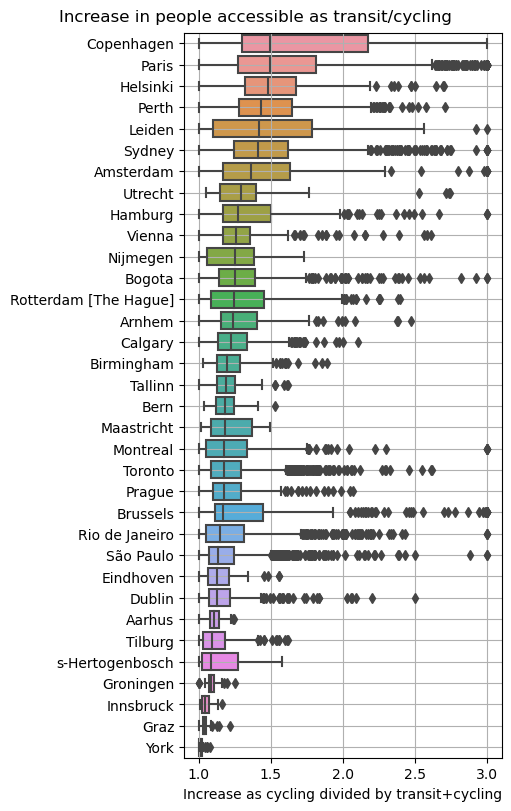

In [42]:
fig, ax = plt.subplots(figsize=(5, 8), constrained_layout=True)
fig.suptitle('Increase in people accessible as transit/cycling')
sns.boxplot(query, y='city_name', x='transit_bike_factor', ax=ax,
            order=query.groupby('city_name').transit_bike_factor.median().sort_values(ascending=False).index)
ax.set_ylabel('')
ax.set_xlabel('Increase as cycling divided by transit+cycling')
plt.grid()

AttributeError: 'Figure' object has no attribute 'set_title'

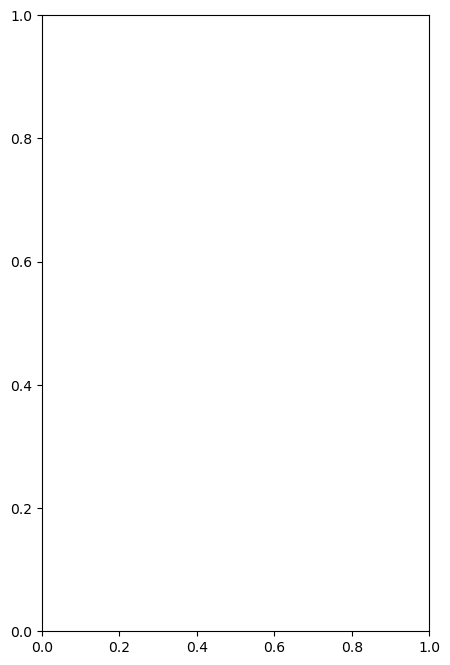

In [43]:
fig, ax = plt.subplots(figsize=(5, 8))
fig.set_title('Increase in pop_reach transit/walking')
sns.boxplot(query, y='city_name', x='transit_walk_factor', ax=ax,
            order=query.groupby('city_name').transit_bike_factor.median().sort_values(ascending=False).index)
plt.grid()

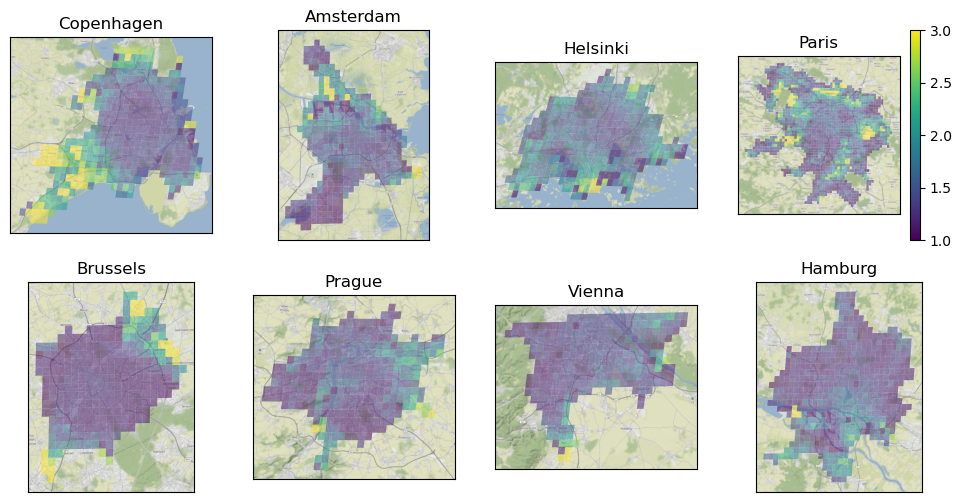

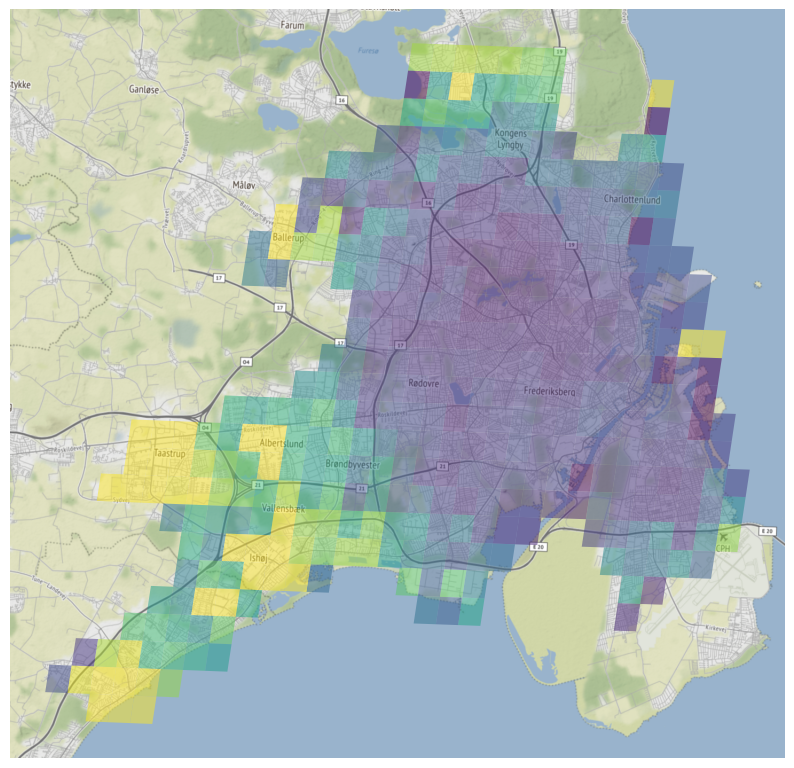

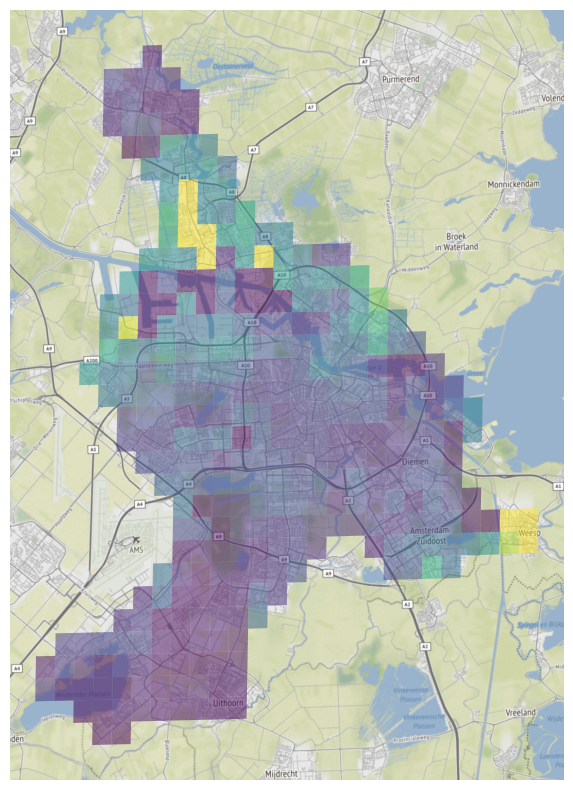

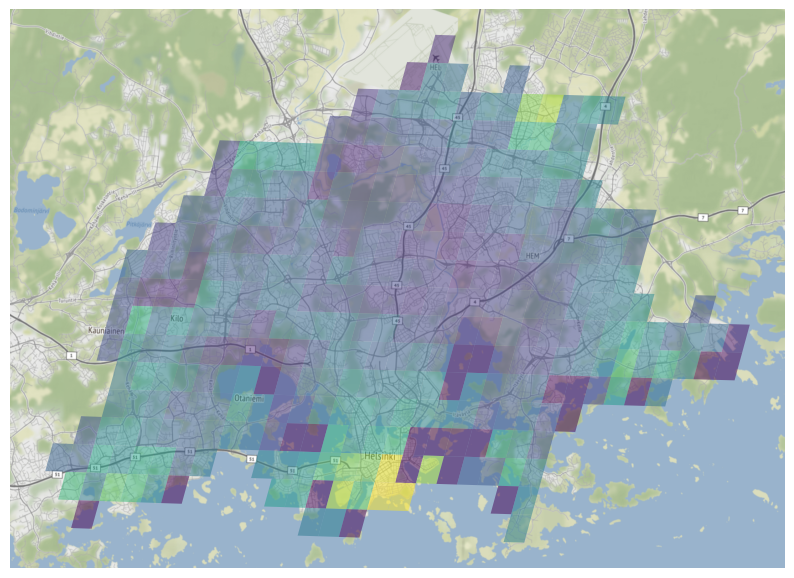

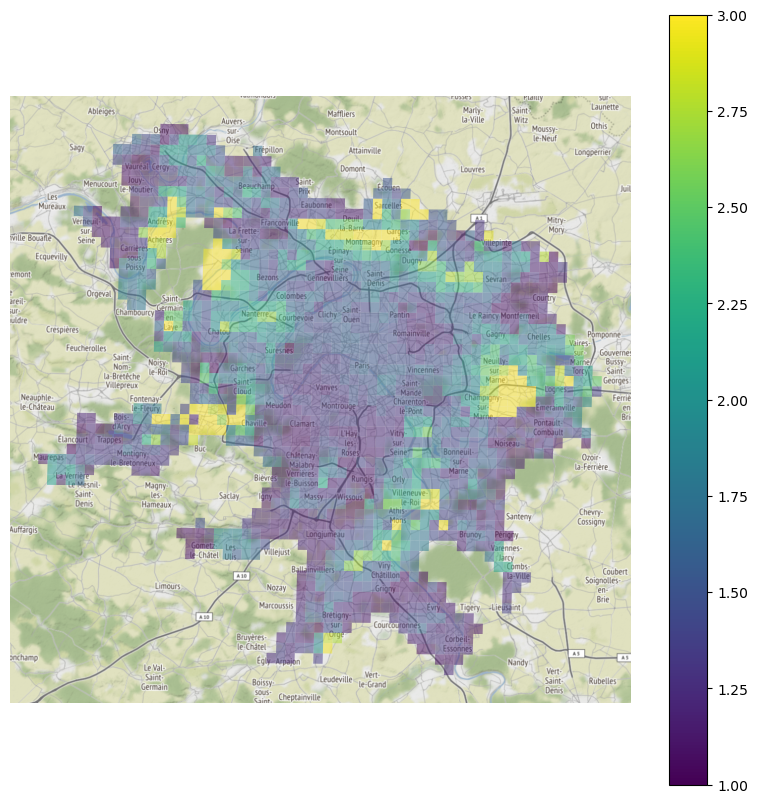

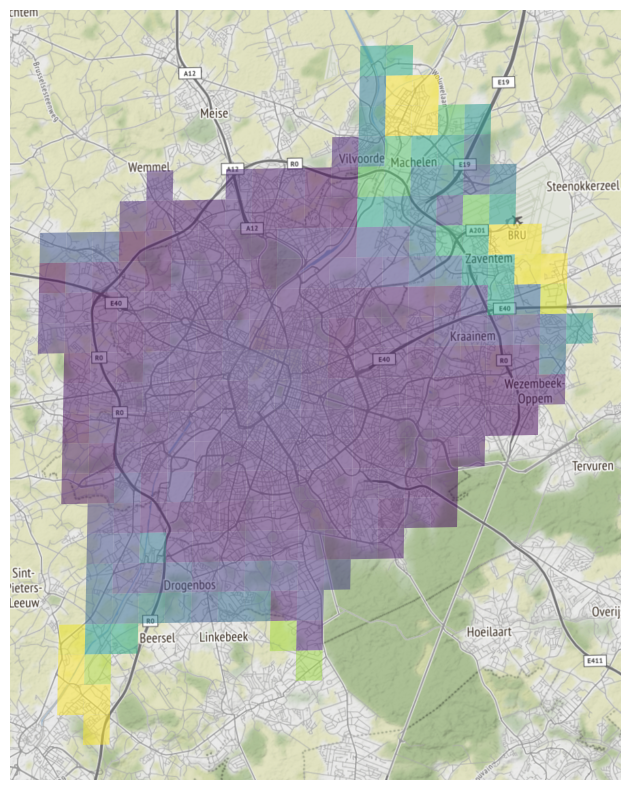

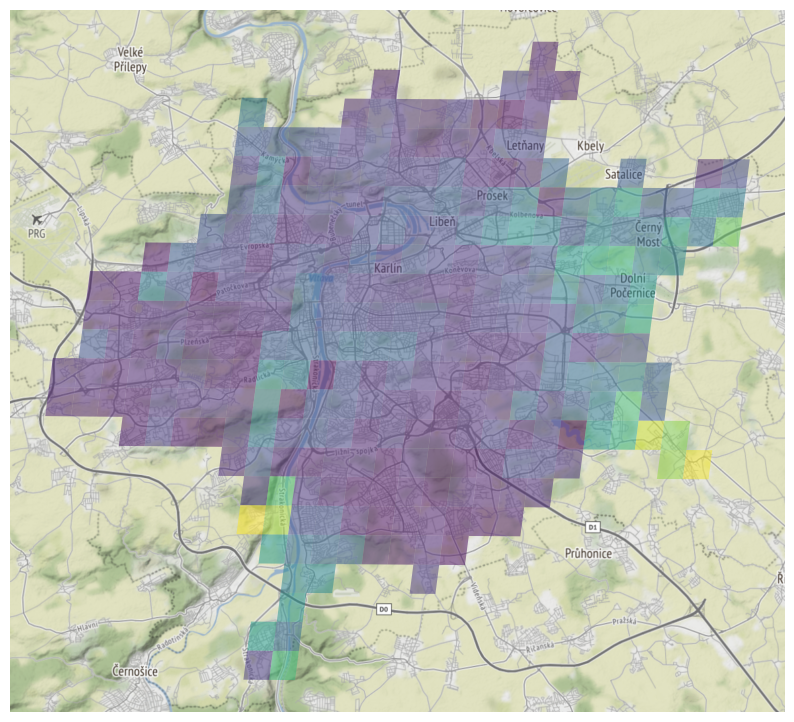

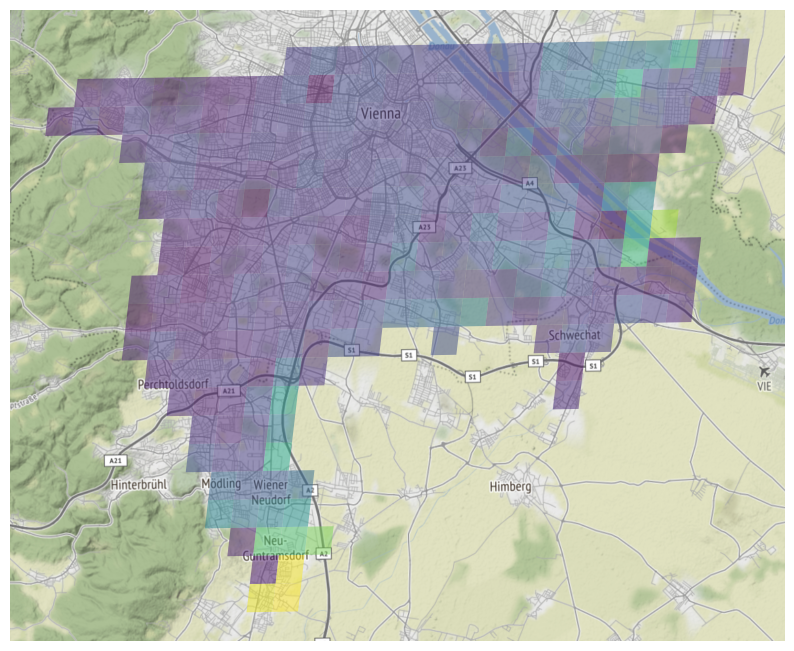

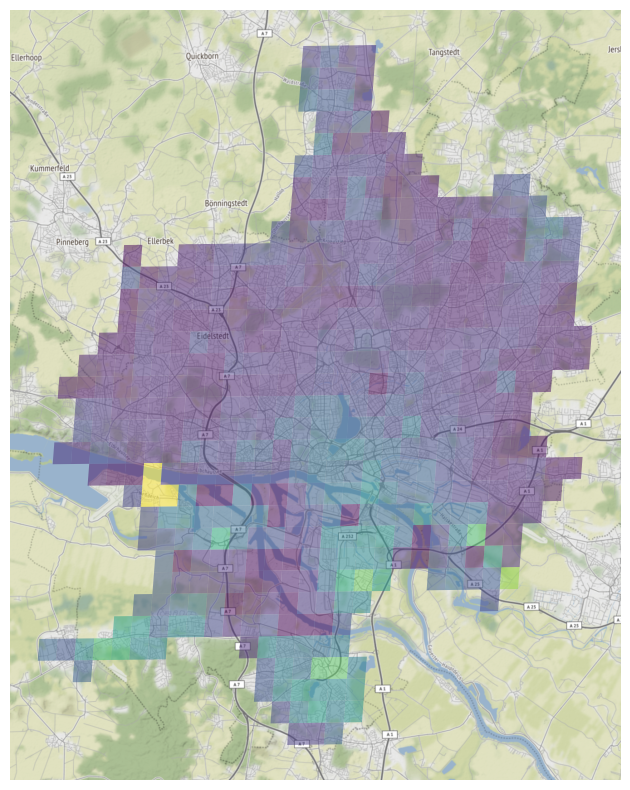

In [44]:
selection = ['Copenhagen', 'Amsterdam', 'Helsinki', 'Paris', 'Brussels', 'Prague', 'Vienna', 'Hamburg']
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,6))

for i, city in enumerate(selection):
    sample = query[query.city_name == city].set_geometry('raster')
    sample = sample.to_crs(sample.estimate_utm_crs())
    ax = axs[i//4, i%4]
    ax.set_title(city)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    
    sample.plot(column='transit_bike_factor', legend=i==3, ax=ax, alpha=0.5)
    ctx.add_basemap(ax=ax, crs=sample.crs, attribution="")
    
    fig1, ax1 = plt.subplots(figsize=(10,10))
    ax1.axis('off')
    sample.plot(column='transit_bike_factor', legend=i==3, ax=ax1, alpha=0.5)
    ctx.add_basemap(ax=ax1, crs=sample.crs, attribution="")
    fig1.savefig(f'../1-data/4-images/pt-reach-expansion/{city}.png')